# Interview Hacking via NLP: The Basics

In this notebook, I will be detailing the application of some very basic NLP tools to do Text Summarization by Weighted Frequency of Occurrence.

## Why?

I was recently doing interview prep for a series of interviews for a position with Collective Health,\
a San Francisco-based healthcare technology start-up. They run a series on their blog titled "Meet The Collective,"\
consisting of interviews with a broad cross-section of their employees. I was interested in knowing what the common threads\
are for employees; why did they come to CH? What do they enjoy about it? What are their unifying experiences?

So, I got to work to find out!

### Imports And Prep

We're using:\
requests to pull the information we want from the blog;\
BeautifulSoup and regex clean the text;\
NLTK to process the text;\
WordCloud and MatPlotLib to vizualize;\
and heapq to help parse our NLTK results.

Since the focus here is on the NLP, not the web scraping, we'll be iterating over some links I've already gathered;\
a collection of "Meet The Collective" articles.

In [234]:
from bs4 import BeautifulSoup as bs4
import requests
import nltk
from nltk.tokenize import RegexpTokenizer
import heapq
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [204]:
# just in case NLTK is missing something we need

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/austie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [208]:
links = ['https://blog.collectivehealth.com/meet-the-collective-hi-abbie-d786e9518f2a?source=collection_home---4------0-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-jamie-9bd2007623a5?source=collection_home---4------1-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-ben-c94bd55e102d?source=collection_home---4------2-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-vita-a94b4ad71c0b?source=user_profile---------1-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-marianne-holt-director-of-benefits-innovation-15b6cdd531f9?source=user_profile---------2-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-haleigh-tebben-chief-business-development-officer-7c49c972e35e?source=user_profile---------3-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-quentin-blanton-1337ee28516f?source=user_profile---------4-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-dave-7d442265ce3a?source=user_profile---------5-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-karlene-1a6458f83091?source=user_profile---------6-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-alina-47e857703632?source=user_profile---------7-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-sanjay-basu-director-of-research-analytics-e2978bbdbfc7?source=user_profile---------8-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-carl-db7843f0ecef?source=user_profile---------9-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-kavita-d34ae5f0b65c?source=user_profile---------10-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-dina-segro-regional-vice-president-northeast-96d0677e9d13?source=user_profile---------11-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-jennifer-jacobs-vice-president-of-operations-4ac1a6afc26f?source=user_profile---------12-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-michael-nikunen-vice-president-of-strategic-accounts-1198438c7704?source=user_profile---------13-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-kevin-francis-chief-commercial-officer-5521a67a4780?source=user_profile---------14-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-karen-boone-joins-our-board-of-directors-8ae822cc0374?source=user_profile---------15-----------------------',
         'https://blog.collectivehealth.com/meet-the-collective-hi-laura-c3f39af7d447?source=user_profile---------16-----------------------']

## Preprocessing

For every link:
1) We use BeautifulSoup and requests to pull only the actual text of the interview (contained within a certain layer of HTML \<p> tags) out of webpage.\
2) We use regex to split the text into sentences based on terminal punctuation.\
3) We rejoin the split text, unifying puncutacion and spacing between sentences; this helps prevent sentences from bleeding into each other later.\
4) We add the text from that link to our list of text.

Finally, we join our list of article texts into a single body of text.

In [210]:
text = []

for x in links:
    soup = bs4(requests.get(x).text).select('p')
    soup = soup[0].parent.parent.get_text()
    soup = re.split(r'(?<=[a-zA-Z”\s+])[.?!](?=[a-zA-Z“\s*])', soup)
    soup = '. '.join(soup)
    text.append(soup)

text = '\n'.join(text)

## NLP!

Now that we have our corpus ready, we can begin in earnest.

### Tokenizing

Here we're using NLTK to tokenize our text in two different ways; by word, and by sentence.

In [235]:
tokenizer = RegexpTokenizer('\w+')
words = tokenizer.tokenize(text)

sent = nltk.sent_tokenize(text)

### Weighted Frequency

NLTK allows us to easily count the number of times that each word occurs in our text with nltk.FreqDist();\
by dividing the number of occurences of a word by the total number of words in our text,\
we can find the weighted frequency that each word occurs.

In [239]:
freq = nltk.FreqDist(words)
max_freq = max(freq.values())

for word in freq.keys():
  freq[word] = freq[word]/max_freq

## Scoring And Summarization

This is where the magic really happens!\
For every sentence:

1) Only consider the sentence if it has less than 30 words (we're summarizing, keep it snappy!);\
2) Tokenize every word in that sentence;\
3) Sum the weighted frequencies of every tokenized word in the sentence.

Once that is done, we're using heapq to pull the sentences with the largest scores.\
in this case, the first twelve highest-scored sentences are the questions CH asks in every "Meet The Collective" interview,\
so we're pulling the top twenty-seven sentences; the common questions, and a fifteen-sentence summary of the interviews.

In [227]:
sentence_scores = {}
for x in sent:
    if len(x.split(' ')) < 30:
        for word in nltk.word_tokenize(x.lower()):
            if word in freq.keys():
                if x not in sentence_scores.keys():
                    sentence_scores[x] = freq[word]
                else:
                    sentence_scores[x] += freq[word]

### Summary

In [228]:
summary_sentences = heapq.nlargest(27, sentence_scores, key=sentence_scores.get)

summary = '\n\n'.join(summary_sentences[12:])

print(summary)

with open('CH_interview_summary.txt', 'w') as f:
    for x in summary_sentences[12:]:
        f.write(f'{x}\n')
    f.close()

Employees’ minds tend to go to the perks of a company, but culture shows up in the minutiae of the day to day.

The fact that we can’t live up to that is pretty sad, so I love the idea of working for a company that’s going to make it better.

Coming from one of the most valued and impactful companies in the world, I wanted to work on something that I felt was destined to make a mark.

I’m just really excited to see the impact it’s going to be able to have as more and more companies bring it on to their platform.

My idea of a great day is hanging out in the backyard, spending time with the kids, and having a nice meal and bottle of wine.

One meal you’d eat for the rest of your life:The idea of eating one meal for the rest of my life is a real bummer.

In all industries and at companies of all sizes — employee healthcare needs to be central to your workforce strategy, demanding the attention of the C-suite.

What really drew me in was the reading the Medium article about why Ali and Ra

### Questions

In [229]:
questions = '\n\n'.join(summary_sentences[:12])

print(questions)

with open('CH_questions.txt', 'w') as f:
    for x in summary_sentences[:12]:
        f.write(f'{x}\n')
    f.close()

As a kid, what did you want to be when you grew up and how does that inform what you do today.

What’s one of the most important lessons you’ve learned in your career.

What’s your favorite thing to do.

What happened in your career that led you to Collective Health.

What would you challenge the rest of the team to.

How would you explain what you do to a 5-year-old.

What excites you most about where Collective Health is going.

What’s the best thing about your job.

Why did you make the move.

What were you up to before Collective Health.

Where are you from.

As a kid, what did you want to be when you grew up.


## Word Cloud!

As a bonus, here's a quick, neat little vizualization of our word frequencies.

We're using NLTK to help filter our words and find the frequencies, and heapq to pull the fourty most-common words;\
these get fed into WordCloud to generate our image.

In [230]:
viz_words = [x for x in words if x not in nltk.corpus.stopwords.words('english')]
viz_words = [x for x in viz_words if x not in ['thing', 'min', 'really', 'wanted', 'way', 'want', 'going']]
viz_freq = nltk.FreqDist(viz_words)
x = heapq.nlargest(40, viz_freq, key=viz_freq.get)

In [237]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 15))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.savefig('wordcloud.png');

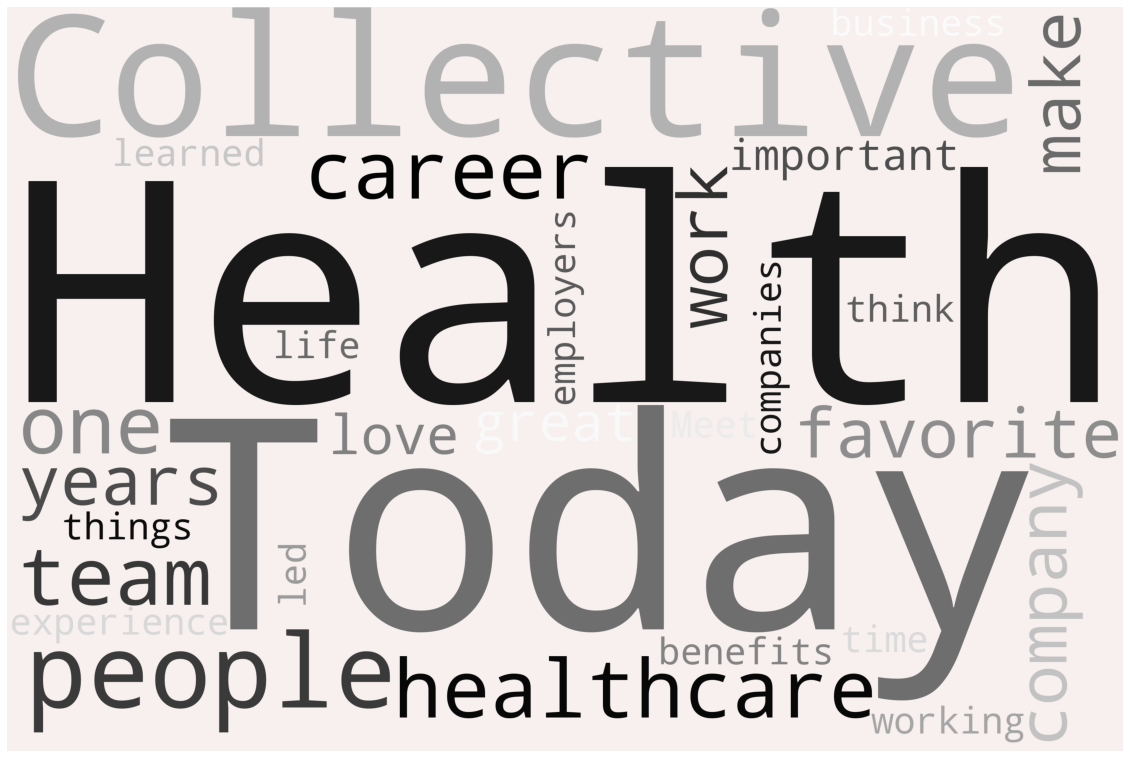

In [238]:
wordcloud = WordCloud(width=3000, height=2000, random_state=1, 
                      background_color='#f7f0ee', colormap='binary_r', 
                      collocations=False, stopwords=STOPWORDS).generate(' '.join(x))

plot_cloud(wordcloud)